In [1]:
import time
import torch

In [2]:
import torch.nn as nn

In [3]:
# utilities
from cbfverify_barrier_fastlin import get_weights

In [4]:
# Output bounds, Batch
from cbfverify_barrier_fastlin_batch import get_barrier_bounds_fastlin_batch

# Output bounds, Original (Non-Batch)
from cbfverify_barrier_fastlin import get_barrier_bounds_fastlin

In [5]:
# Lie bounds, Batch (originally supported)
from cbfverify_lie import get_lie_derivative_bounds

In [6]:
# 1-layer network with ReLU activation
dim_in, dim_out, num_hidden, num_batch = 3, 1, 256, 1
model = nn.Sequential(
    nn.Linear(dim_in,num_hidden),
    nn.ReLU(),
    nn.Linear(num_hidden,dim_out)
)

In [7]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

Sequential(
  (0): Linear(in_features=3, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=1, bias=True)
)

In [8]:
Ws, bs = get_weights(model)

W0:torch.Size([256, 3])
b0:torch.Size([256])
W1:torch.Size([1, 256])
b1:torch.Size([1])


In [9]:
# 10k samples
num_sample = 10000
x0 = torch.rand(dim_in,num_sample) # shape: (dim_in, num_batch)

In [10]:
# perturbation magnitude
eps = 0.1

## Network Output Bounds, FastLin

In [11]:
start = time.time()
non_batch_UBs = []
non_batch_LBs = []
for i in range(x0.shape[1]):
    x = x0[:,[i]]
    UBs, LBs = get_barrier_bounds_fastlin(x, eps, Ws, bs, method="fastlin", activation="relu")
    non_batch_UBs.append(UBs[-1][0, 0])
    non_batch_LBs.append(LBs[-1][0, 0])
fastlin_elapsed_non_batch = time.time() - start

In [12]:
print("Time elapsed (non_batch version): {}".format(fastlin_elapsed_non_batch))

Time elapsed (non_batch version): 3.936497926712036


In [13]:
non_batch_UBs = torch.FloatTensor(non_batch_UBs)
non_batch_LBs = torch.FloatTensor(non_batch_LBs)

In [14]:
start = time.time()
UBs, LBs = get_barrier_bounds_fastlin_batch(x0, eps, Ws, bs, method="fastlin", activation="relu")
fastlin_elapsed_batch = time.time() - start

In [15]:
print("Time elapsed (batched version): {}".format(fastlin_elapsed_batch))

Time elapsed (batched version): 0.6828396320343018


In [16]:
batch_UBs = UBs[-1].squeeze()
batch_LBs = LBs[-1].squeeze()

### Check output bounds correctness

In [17]:
torch.allclose(non_batch_UBs, batch_UBs, atol=1e-07)

True

In [18]:
torch.allclose(non_batch_LBs, batch_LBs, atol=1e-07)

True

### Comparison: batched FastLin vs batched ibp

In [19]:
from cbfverify_barrier_fastlin import get_barrier_bounds_ibp

In [20]:
start = time.time()
UBs, LBs = get_barrier_bounds_ibp(x0, eps, Ws, bs, activation="relu")
ibp_elapsed_batch = time.time() - start

In [21]:
print("Time elapsed (batched ibp): {}".format(ibp_elapsed_batch))

Time elapsed (batched ibp): 0.010169506072998047


In [22]:
print("UB: {}, LB: {}".format(UBs[-1][0][0], LBs[-1][0][0]))

UB: 0.41615548729896545, LB: -0.17780260741710663


In [23]:
start = time.time()
UBs, LBs = get_barrier_bounds_fastlin_batch(x0, eps, Ws, bs, method="fastlin", activation="relu")
fastlin_elapsed_batch = time.time() - start

In [24]:
print("Time elapsed (batched fastlin): {}".format(fastlin_elapsed_batch))

Time elapsed (batched fastlin): 0.6944561004638672


In [25]:
print("UB: {}, LB: {}".format(UBs[-1][0][0], LBs[-1][0][0]))

UB: 0.17525365948677063, LB: 0.049879517406225204


## Lie Derivative Bounds

In [26]:
start = time.time()
non_batch_UBs = []
non_batch_LBs = []
for i in range(x0.shape[1]):
    x = x0[:,[i]]
    UBs, LBs = get_lie_derivative_bounds(x, eps, Ws, bs, activation="relu")
    non_batch_UBs.append(UBs[0])
    non_batch_LBs.append(LBs[0])
lie_elapsed_non_batch = time.time() - start

In [27]:
print("Time elapsed (non_batch_version): {}".format(lie_elapsed_non_batch))

Time elapsed (non_batch_version): 2.3382973670959473


In [28]:
non_batch_UBs = torch.stack(non_batch_UBs).squeeze()
non_batch_LBs = torch.stack(non_batch_LBs).squeeze()

In [29]:
start = time.time()
UBs, LBs = get_lie_derivative_bounds(x0, eps, Ws, bs, activation="relu")
lie_elapsed_batched = time.time() - start

In [30]:
print("Time elapsed (batched version): {}".format(lie_elapsed_batched))

Time elapsed (batched version): 0.049223899841308594


In [31]:
batch_UBs = UBs.squeeze()
batch_LBs = LBs.squeeze()

### Check Lie bounds correctness

In [32]:
torch.allclose(non_batch_UBs, batch_UBs, atol=1e-07)

True

In [33]:
torch.allclose(non_batch_LBs, batch_LBs, atol=1e-07)

True

#### Check Lie propagation with ReLU

In [34]:
x0_in = x0.T
x0_in = x0_in.requires_grad_(True)

In [35]:
# Gradients given by pytorch's autograd
all_grads = []
for x0_single in x0_in:
    x0_single = x0_single.unsqueeze(0)
    grads = torch.autograd.grad(model(x0_single),x0_single)
    all_grads.append(grads[0])

In [36]:
autograd_res = torch.vstack(all_grads)

In [37]:
from cbfverify_lie import forward_prop_lie

In [38]:
# Our own propagation
all_grads = forward_prop_lie(Ws,bs,x0,activation='relu')

In [39]:
imp_res = all_grads.squeeze()

In [40]:
torch.allclose(autograd_res, imp_res, atol=1e-07)

True

#### Validate Lie derivative bounds

In [41]:
from cbfverify_lie import validate_bounds, show

In [42]:
violation_UBs, violation_LBs = validate_bounds(x0, eps, Ws, bs)

pass validation of UB!
pass validation of LB!


In [43]:
x0.shape

torch.Size([3, 10000])

In [44]:
import matplotlib.pyplot as plt

In [45]:
idx = 0

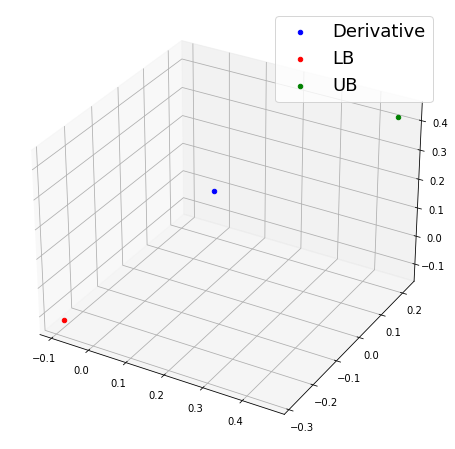

In [46]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter(*imp_res[idx], c='b', label='Derivative')
ax.scatter(*batch_LBs[idx], c='r', label='LB')
ax.scatter(*batch_UBs[idx], c='g', label='UB')
plt.legend(fontsize=18)